In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import os

In [ ]:
# create a dataset using torch.dataset for estimating the sinc function
class ExpDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples, n_targets=1, n_features=1):
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_targets = n_targets
        self.data = np.random.uniform(-10, 10, (n_samples, n_features))
        self.target = np.exp(-self.data)
        self.data = torch.tensor(self.data, dtype=torch.float32)
        self.target = torch.tensor(self.target, dtype=torch.float32)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

# create a simple neural network
class Net(nn.Module):
    def __init__(self, n_features, n_targets):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc4 = nn.Linear(30, n_targets)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
# Instantiate the dataset
n_samples = 10000
n_features = 1
n_targets = 1
dataset = ExpDataset(n_samples, n_features, n_targets)

# Create a dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Instantiate the model
model = Net(n_features, n_targets).to('cuda:0')

# Define a loss function and an optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    for batch in dataloader:
        # Get the data and targets from the batch
        data, targets = batch[0].to('cuda:0'), batch[1].to('cuda:0')

        # Forward pass
        output = model(data)

        # Compute the loss
        loss = loss_fn(output, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{n_epochs} Loss: {loss.item()}")

# plot the model predictions against the true targets
import matplotlib.pyplot as plt
with torch.no_grad():
    x = torch.linspace(-10, 10, 1000).view(-1, 1).to('cuda:0')
    target = torch.sin(x).squeeze().detach().cpu()
    predictions = model(x).squeeze().detach().cpu()
    x_in = x.squeeze().detach().cpu()
    plt.plot(x_in, target)
    plt.plot(x_in, predictions, c='r')
    plt.xlabel('True targets')
    plt.ylabel('Predictions')
    plt.show()

In [ ]:
def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input."""
    return torch.autograd.grad(
        outputs, 
        inputs, 
        grad_outputs=torch.ones_like(outputs), 
        create_graph=True
    )

def physics_loss(model: torch.nn.Module, device="cuda:0"):
    """The physics loss of the model"""
    # run the collocation points through the network
    out = model(x)
    # get the gradient
    gr = grad(out, x)[0]
    # compute the ODE
    true_grad = - torch.exp(-x)
    ode = (gr - true_grad)
    # MSE of ODE
    return torch.mean(ode**2)

# define a new loss function
class SincLoss(nn.Module):
    def __init__(self):
        super(SincLoss, self).__init__()

    def forward(self, output, target, gradient_output, gradient_target):
        mse_loss        = torch.mean((torch.sinc(output) - torch.sinc(target))**2)
        return 0.5*(mse_loss)

In [ ]:
# Instantiate the dataset
n_samples = 10000
n_features = 1
n_targets = 1
dataset = ExpDataset(n_samples, n_features, n_targets)

# Create a dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Instantiate the model
model = Net(n_features, n_targets).to('cuda:0')

# Define a loss function and an optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    for batch in dataloader:
        # Get the data and targets from the batch
        data, targets = batch[0].to('cuda:0'), batch[1].to('cuda:0')

        # Forward pass
        output = model(data)

        # Compute the loss
        loss = loss_fn(output, targets) + 0.1*physics_loss(model)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{n_epochs} Loss: {loss.item()}")

In [ ]:
# plot the model predictions against the true targets
import matplotlib.pyplot as plt
with torch.no_grad():
    x = torch.linspace(-20, 20, 1000).view(-1, 1).to('cuda:0')
    target = torch.exp(-x).squeeze().detach().cpu()
    predictions = model(x).squeeze().detach().cpu()
    x_in = x.squeeze().detach().cpu()
    plt.plot(x_in, target)
    plt.plot(x_in, predictions, c='r')
    plt.xlabel('True targets')
    plt.ylabel('Predictions')
    plt.show()

In [ ]:
target[500]

In [ ]:
# plot torch.exp(-x)
with torch.no_grad():
    x = torch.linspace(-20, 20, 1000).view(-1, 1).to('cuda:0')
    target = torch.exp(-x.squeeze()).detach().cpu()
    x_in = x.squeeze().detach().cpu()
    plt.plot(x_in, target)
    plt.xlabel('x')
    plt.ylabel('exp(-x)')
    plt.show()

In [ ]:
torch.exp(torch.tensor(-1))

---


In [149]:
Tenv = 25
T0 = 100
R = 0.005

def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to("cuda:0")
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    
    return torch.mean(pde**2)

RuntimeError: If `is_grads_batched=True`, we interpret the first dimension of each grad_output as the batch dimension. The sizes of the remaining dimensions are expected to match the shape of corresponding output, but a mismatch was detected: grad_output[0] has a shape of torch.Size([]) and output[0] has a shape of torch.Size([1000, 1]). If you only want some tensors in `grad_output` to be considered batched, consider using vmap.

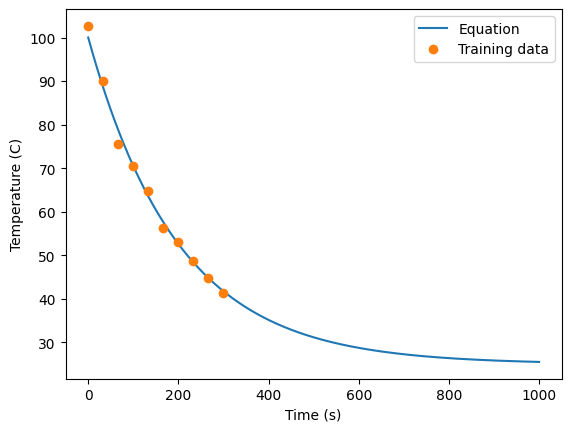

In [147]:
import functools
np.random.seed(10)

times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

model = Net(1,1).to(device="cuda:0")

# Define a loss function and an optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 3000

for epoch in range(n_epochs):
    # Get the data and targets from the batch
    data = torch.tensor(t, dtype=torch.float32).view(-1,1).to(device="cuda:0")
    targets = torch.tensor(T, dtype=torch.float32).view(-1,1).to(device="cuda:0")

    # Forward pass
    output = model(data)

    # Compute the loss
    loss = loss_fn(output, targets) + physics_loss(model)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{n_epochs} Loss: {loss.item()}")

In [ ]:
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
T = eq(times)
x = torch.tensor(times, dtype=torch.float32).reshape(-1, 1).to("cuda:0")

preds = model(x).detach().cpu()

plt.plot(times, temps, alpha=0.8)
plt.plot(x.detach().cpu(), T, 'o')
plt.plot(x.detach().cpu(), preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')
plt.show()

---

In [176]:
def f(x,y):
    return np.hstack([x**2*y, y**2])

#create dataset for f using torch.dataset
class FDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples, n_features=2):
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_targets = n_targets
        self.data = np.random.uniform(-10, 10, (n_samples, n_features))
        self.target = f(self.data[:,0].reshape(-1, 1), self.data[:,1].reshape(-1, 1))
        self.data = torch.tensor(self.data, dtype=torch.float32, requires_grad=True)
        self.target = torch.tensor(self.target, dtype=torch.float32, requires_grad=True)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

# create a simple neural network
class Net(nn.Module):
    def __init__(self, n_features, n_targets):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc4 = nn.Linear(30, n_targets)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the dataset
n_samples = 10000
n_features = 2
n_targets = 2
dataset = FDataset(n_samples, n_features)

#create a dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

In [177]:
def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

def jacobian(func, inputs):
    return torch.autograd.functional.jacobian(func, inputs, create_graph=True)

In [179]:
net = Net(n_features, n_targets).to('cuda:0')
for data, target in dataloader:
    data = data.to('cuda:0')
    target = target.to('cuda:0')
    output = net(data)
    
    gradient = jacobian(net, data)
    break

gradient.shape

torch.Size([5, 2, 5, 2])

In [171]:
output

tensor([[0.0310]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [1]:
import torch
print (torch.__version__)

2.1.2


In [31]:
g = torch.tensor ([[5.0, 7.0], [8.0, 9.0]], requires_grad = True)

T = torch.cat([(g[0]*g[1]).reshape(-1, 1), (g[0]**2).reshape(-1, 1)], dim=1)

print("g:", g)
print("T:", T)

g: tensor([[5., 7.],
        [8., 9.]], requires_grad=True)
T: tensor([[40., 25.],
        [63., 49.]], grad_fn=<CatBackward0>)


In [32]:
torch.autograd.functional.jacobian(lambda g: T, g)

tensor([[[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]]])

In [34]:
torch.autograd.grad(T[0], g, grad_outputs=torch.ones_like(T[0]), create_graph=True)

(tensor([[18.,  0.],
         [ 5.,  0.]], grad_fn=<AddBackward0>),)

In [ ]:
T_x = torch.autograd.grad (T, g[0], retain_graph=True, create_graph=True, allow_unused=True)   # creates graph of first derivative